In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

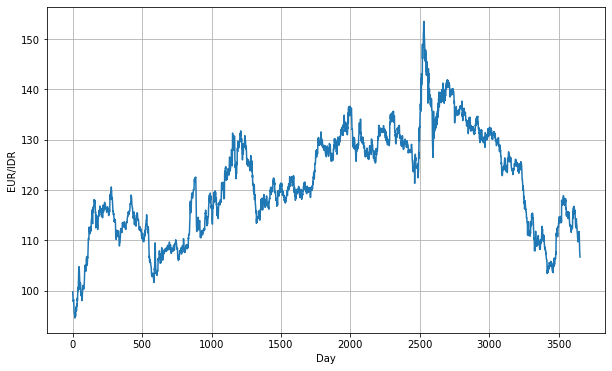

In [50]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./currency_data_10_years.csv') as csvfile:
  
    # Initialize reader
    reader = csv.reader(csvfile, delimiter=',')

    # Skip the first line
    next(reader)

    # Append row and sunspot number to lists
    for i,row in enumerate(reader):
        time_step.append(int(i))
        sunspots.append(float(row[3]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Day', ylabel='EUR/IDR')

In [51]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [52]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [53]:
# Parameters
window_size = 30
batch_size = 128

shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [54]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


In [55]:

# Get initial weights
init_weights = model.get_weights()

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)


In [56]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-11 * 10**(epoch / 10))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
24/24 [==============================] - 1s 20ms/step - loss: 207.7241 - lr: 1.0000e-11
Epoch 2/100
24/24 [==============================] - 1s 15ms/step - loss: 207.7230 - lr: 1.2589e-11
Epoch 3/100
24/24 [==============================] - 1s 16ms/step - loss: 207.7211 - lr: 1.5849e-11
Epoch 4/100
24/24 [==============================] - 1s 18ms/step - loss: 207.7184 - lr: 1.9953e-11
Epoch 5/100
24/24 [==============================] - 1s 15ms/step - loss: 207.7146 - lr: 2.5119e-11
Epoch 6/100
24/24 [==============================] - 1s 16ms/step - loss: 207.7095 - lr: 3.1623e-11
Epoch 7/100
24/24 [==============================] - 1s 15ms/step - loss: 207.7027 - lr: 3.9811e-11
Epoch 8/100
24/24 [==============================] - 0s 14ms/step - loss: 207.6941 - lr: 5.0119e-11
Epoch 9/100
24/24 [==============================] - 1s 14ms/step - loss: 207.6830 - lr: 6.3096e-11
Epoch 10/100
24/24 [==============================] - 1s 14ms/step - loss: 207.6689 - lr: 7.9433e-11

KeyboardInterrupt: 

(1e-11, 1e-06, 0.0, 20000.0)

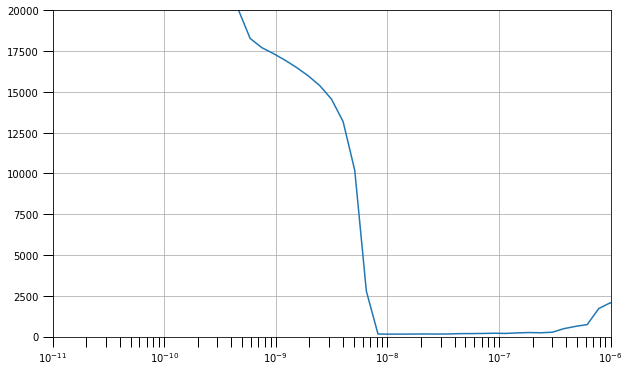

In [63]:
# Define the learning rate array
lrs = 1e-11 * (11 ** (np.arange(100) / 10))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-11, 1.e-6, 0, 20000])

In [57]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [58]:
# Set the learning rate
learning_rate = 1e-7

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [59]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
24/24 [==============================] - 1s 16ms/step - loss: 202.6466 - mae: 203.1466
Epoch 2/100
24/24 [==============================] - 1s 14ms/step - loss: 184.0809 - mae: 184.5809
Epoch 3/100
24/24 [==============================] - 1s 14ms/step - loss: 163.0849 - mae: 163.5849
Epoch 4/100
24/24 [==============================] - 0s 14ms/step - loss: 142.0283 - mae: 142.5283
Epoch 5/100
24/24 [==============================] - 1s 14ms/step - loss: 121.2562 - mae: 121.7562
Epoch 6/100
24/24 [==============================] - 0s 14ms/step - loss: 100.3551 - mae: 100.8551
Epoch 7/100
24/24 [==============================] - 1s 14ms/step - loss: 79.1382 - mae: 79.6382
Epoch 8/100
24/24 [==============================] - 1s 14ms/step - loss: 57.7515 - mae: 58.2515
Epoch 9/100
24/24 [==============================] - 1s 15ms/step - loss: 36.4746 - mae: 36.9746
Epoch 10/100
24/24 [==============================] - 1s 14ms/step - loss: 15.3086 - mae: 15.8086
Epoch 11/100
24/2

24/24 [==============================] - 1s 16ms/step - loss: 1.0553 - mae: 1.4768
Epoch 87/100
24/24 [==============================] - 1s 16ms/step - loss: 1.0592 - mae: 1.4804
Epoch 88/100
24/24 [==============================] - 1s 16ms/step - loss: 1.0582 - mae: 1.4809
Epoch 89/100
24/24 [==============================] - 1s 16ms/step - loss: 1.0583 - mae: 1.4802
Epoch 90/100
24/24 [==============================] - 1s 15ms/step - loss: 1.0558 - mae: 1.4776
Epoch 91/100
24/24 [==============================] - 1s 16ms/step - loss: 1.0525 - mae: 1.4740
Epoch 92/100
24/24 [==============================] - 1s 16ms/step - loss: 1.0531 - mae: 1.4731
Epoch 93/100
24/24 [==============================] - 1s 16ms/step - loss: 1.0530 - mae: 1.4750
Epoch 94/100
24/24 [==============================] - 1s 16ms/step - loss: 1.0505 - mae: 1.4717
Epoch 95/100
24/24 [==============================] - 1s 16ms/step - loss: 1.0519 - mae: 1.4725
Epoch 96/100
24/24 [==============================] -

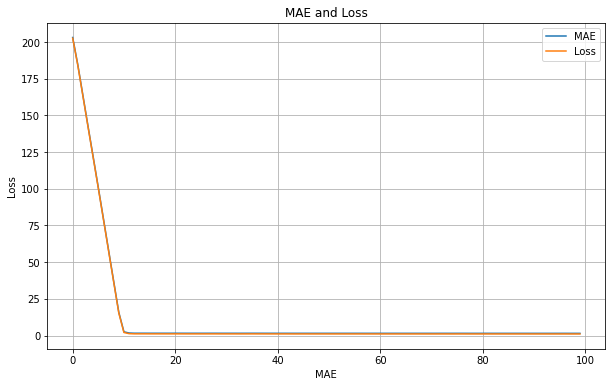

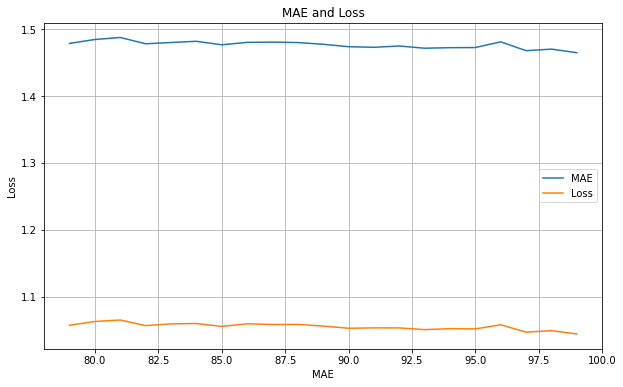

In [60]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.8)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [61]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

6/6 [==============================] - 0s 22ms/step


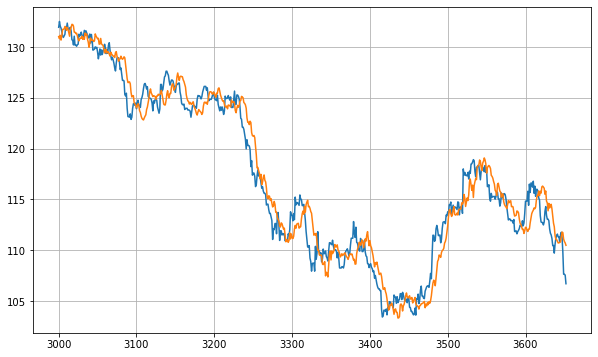

In [62]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [63]:
print(f'2 last Actual Price = {x_valid[-2:]}, Predicted Price = {results[-2:]}')

2 last Actual Price = [107.559654 106.712659], Predicted Price = [110.727844 110.49156 ]


In [64]:
# import os
# path = "./saved_model"

# def get_model_dir():
#     """Returns the path where to save the current model.
#     The path is as follows: './saved_models/{incremental_integer}
#     Note: all sub-directories inside 'saved_models' must have an incremental integer as name

#     Returns:
#     - Path to save a new model (str) 
#     """
#     # create 'saved_models' directory if it does not exist
#     if not os.path.exists(path):
#         os.makedirs(path)

#     # check for model directories inside 'saved_models'
#     model_dirs = [int(i) for i in os.listdir(path)]

#     # if there is no prior model, current model has version 1
#     # otherwise, current model version is highest available version incremented by 1 
#     current_model = "1" if len(model_dirs)==0 else str(max(model_dirs)+1)

#     return path + "/" + current_model + "/"

In [65]:
# # !mkdir -p saved_model
# path = get_model_dir()
# model.save(path)

In [66]:
into_future = 100

# 1. Create function to make preds
def make_future_forecast(values, model, into_future, window_size=window_size) -> list:
    """
    Make future forecasts into_future steps after value ends.

    Returns future forecasts as a list of floats.
    """
    # 2. Create an empty list for future forecasts/prepare data to forecast on
    future_forecast = []
    last_window = values[-window_size:]

    # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each
    for _ in range(into_future):
        # Predict on the last window then append it again, again, again (our model will eventually start to make forecasts on its own forecasts)
        future_pred = model.predict(tf.expand_dims(last_window, axis=0))
#         print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

        # Append preds to future_forecast
        future_forecast.append(tf.squeeze(future_pred).numpy())

        # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
        last_window = np.append(last_window, future_pred)[-window_size:]

    return future_forecast
     

In [67]:
future_forecast = make_future_forecast(values=series,
                                       model=model,
                                       into_future=into_future,
                                       window_size=window_size)

1/1 [==============================] - 0s 19ms/step


In [68]:
next_time_steps = np.arange(time[-1] + 1, time[-1] + 1 + into_future)
next_time_steps

# Insert last timestep/final price into next time steps and future forecasts so the plot connects
next_time_steps = np.insert(next_time_steps, 0, time[-1])
future_forecast = np.insert(future_forecast, 0, series[-1])

In [69]:
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
    """
    Plots timesteps ( a series of points in time) against values (a series of values across timesteps)

    Parameters
    ----------
    timesteps: array of timestep values
    values: array of values across time
    format: style of plot, default "."
    start: where to start the plot (setting a value will index from start of timesteps & values)
    end: where to end the plot (similar to start but for the end)
    label: label to show on plot about values, default None
    """

    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Day")
    plt.ylabel("EUR/IDR Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)

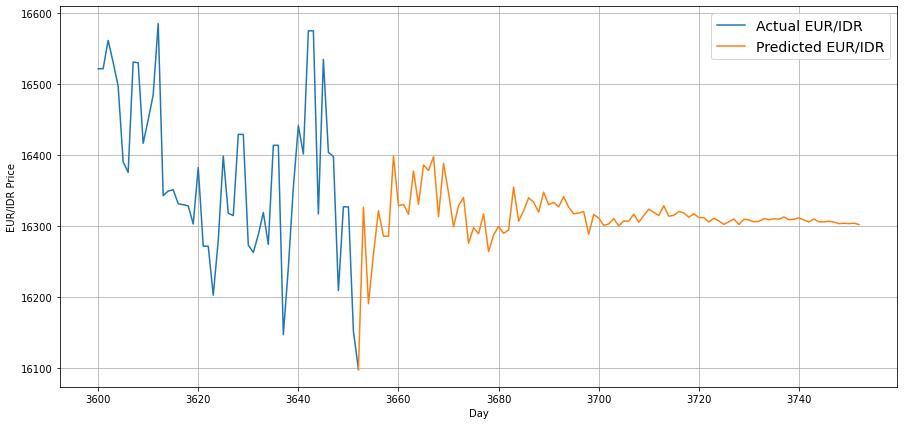

In [32]:
plt.figure(figsize=(15,7))
plot_time_series(time, series, start=3600, format="-", label="Actual EUR/IDR")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted EUR/IDR")

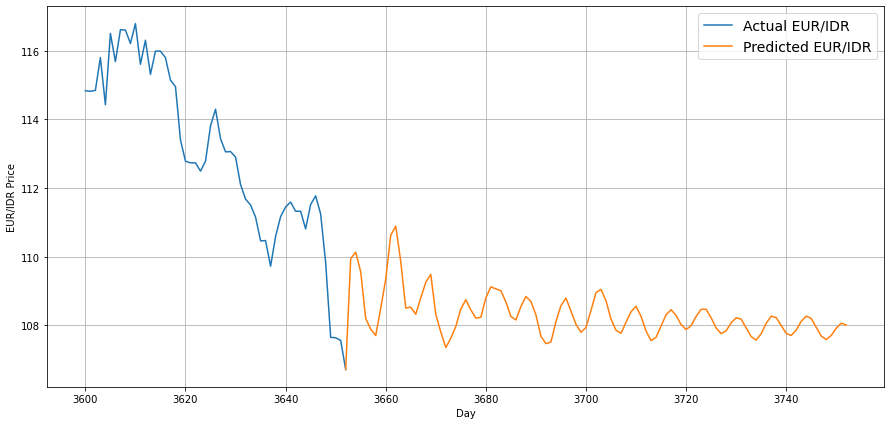

In [70]:
plt.figure(figsize=(15,7))
plot_time_series(time, series, start=3600, format="-", label="Actual EUR/IDR")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted EUR/IDR")